# Deep Image Prior

In the following exercise we will train a notebook for solving the Computed Tomgraphy inverse problem using the Deep Image Prior.

Given the single data $y^\delta$ we will parametrize our reconstruction by the output of the network $\varphi_\Theta$. 

We will solve the problem by minimizing the loss function 

$$L(\Theta) = \Vert A\varphi_\Theta(z) - y^\delta \Vert$$



for some fized random input $z$.




## Load the data

In [0]:
import numpy as np
from skimage.transform import radon, iradon

n, m = 28, 28

###############################################
# TODO: Set number of angles
angles = 5
###############################################

detectors = 40

theta = np.linspace(0.0, 180.0, angles, endpoint=False)

## Operator matrix

In [0]:
operator = np.zeros((detectors * angles, n * m))
for i in range(n * m):
    unit = np.zeros(n * m)
    unit[i] = 1
    operator[:, i] = radon(unit.reshape(n, m), theta, circle=False).reshape(-1)

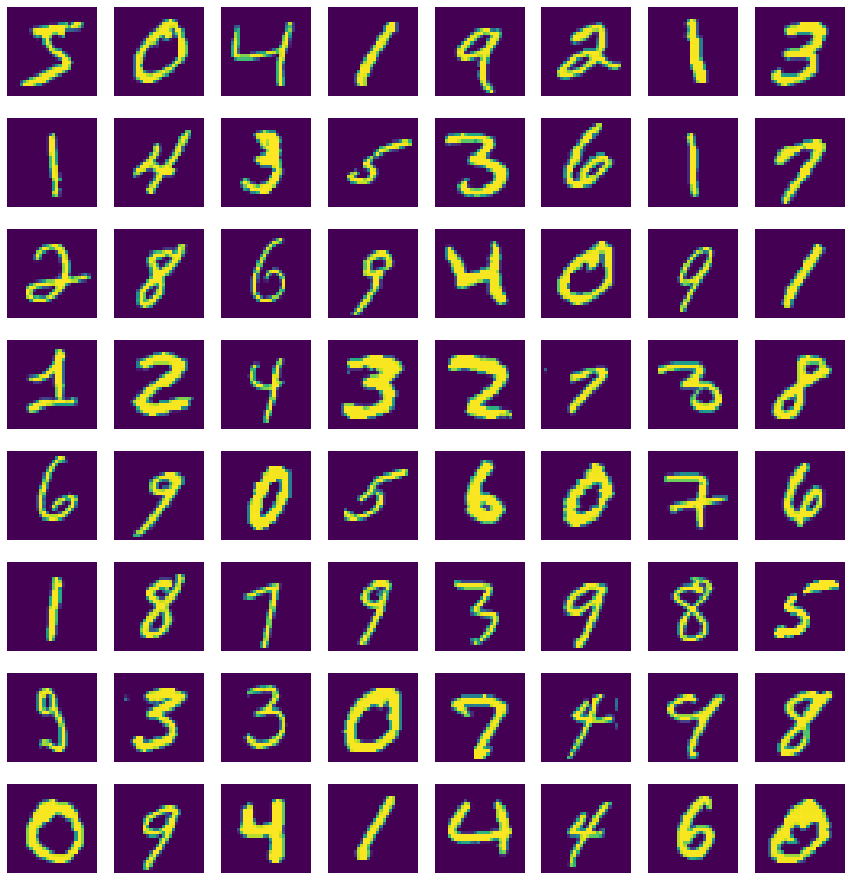

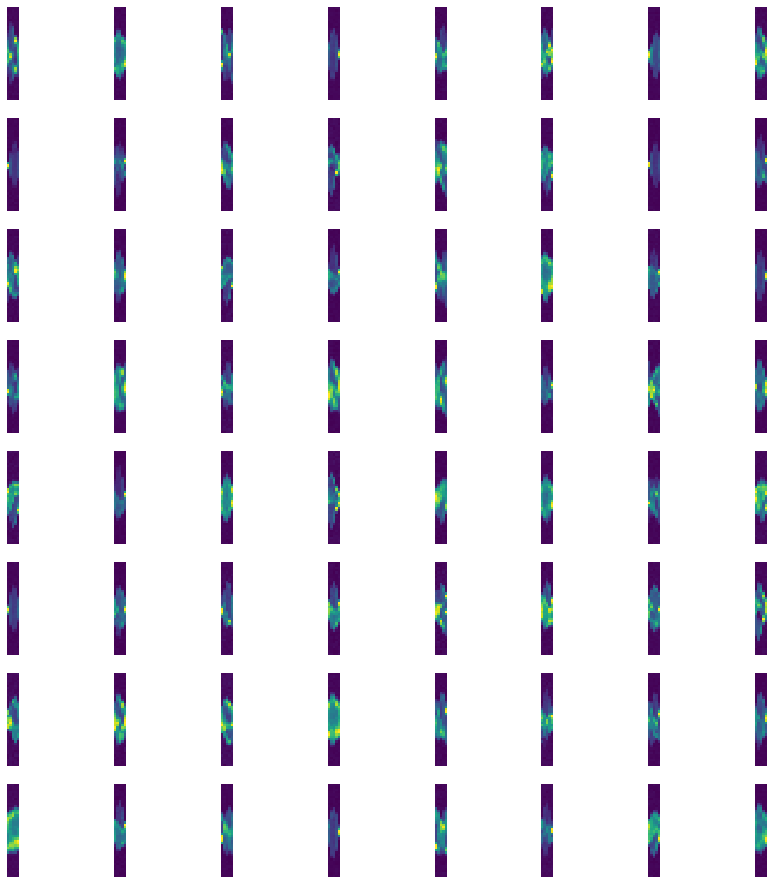

In [3]:
import torch

import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import Dataset

batch_size = 64

transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])


def forward(phantom):
    sinogram = radon(phantom.squeeze(), theta, circle=False)
    sinogram += 0.1 * np.random.normal(size=sinogram.shape)
    return sinogram


class SinogramData(Dataset):
    def __init__(self, dataset, forward):
        super(SinogramData, self).__init__()
        self.dataset = dataset

        for i in range(len(self.dataset)):
            x = self.dataset[i][0]

        self.forward = forward
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        y = torch.tensor(forward(x), dtype=torch.float32)
        return x, y
    
# datasets (MNIST)
mnist_train = SinogramData(datasets.MNIST('/data', train=True, download=True, transform=transform_train), forward)
mnist_test  = SinogramData(datasets.MNIST('/data', train=False, download=True, transform=transform_test), forward)

# dataloaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)


def visualize_batch(batch, ncols=8):
    nrows = (batch.shape[0] + ncols - 1) // ncols
    plt.figure(figsize=(15, 2 * nrows))
    for i in range(batch.shape[0]):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(batch[i].squeeze())
        plt.axis('off')
    plt.show()


x_batch, y_batch = next(iter(train_loader))
visualize_batch(x_batch)
visualize_batch(y_batch)

## Create the neural network

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1),
                                  nn.BatchNorm2d(out_ch),
                                  nn.LeakyReLU(0.2, inplace=True))
        self.conv2 = nn.Sequential(nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
                                  nn.BatchNorm2d(out_ch),
                                  nn.LeakyReLU(0.2, inplace=True))
        self.conv3 = nn.Sequential(nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
                                  nn.BatchNorm2d(out_ch),
                                  nn.LeakyReLU(0.2, inplace=True))
                                  
    def forward(self, x):
        x = self.conv3(self.conv2(self.conv1(x)))
        return x
    
                                  
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv0 = ConvBlock(1, 4)
        self.conv1 = ConvBlock(4, 8, stride=2)
        self.conv2 = ConvBlock(8, 16, stride=2)
        self.conv3 = ConvBlock(16, 16)
        self.conv4 = ConvBlock(16, 8)
        self.conv5 = ConvBlock(8, 4)
        self.conv6 = nn.Conv2d(4, 1, kernel_size=1)

    def forward(self, x0):
        x0 = x0.view(-1, 1, 28, 28)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.up(x)
        x = self.conv4(x)
        x = self.up(x)
        x = self.conv5(x)
        x = self.conv6(x)
        return F.sigmoid(x)

model = Autoencoder()

## Solve Inverse Problem

Choose one single data point $y^\delta$ and obtain a reconstruction with the Deep Image Prior for $x$.


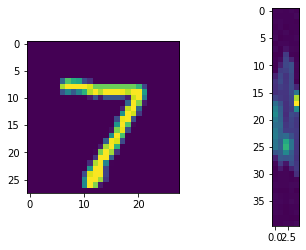

In [5]:
x, y = next(iter(test_loader))
phantom = x[0]
sinogram = y[0]

plt.subplot(1,2,1)
plt.imshow(phantom.squeeze())
plt.subplot(1,2,2)
plt.imshow(sinogram.squeeze())

## Set the hyperparameters, the loss function and the optimizer

In [6]:
###############################################
# TODO: Choose the learning rate
lr = 0.1
###############################################

# number of epochs
n_epochs = 1000

###############################################
# TODO: Choose the loss function
loss_function = nn.MSELoss()
###############################################


###############################################
# TODO: Choose the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
###############################################

# set device to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 0 loss: 102.83482


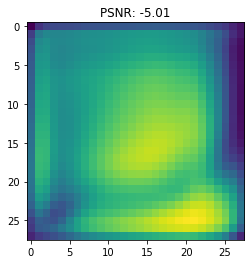

epoch: 50 loss: 1.09125


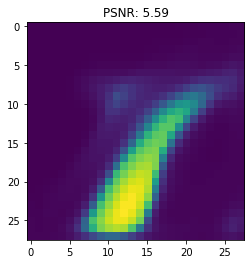

epoch: 100 loss: 0.29338


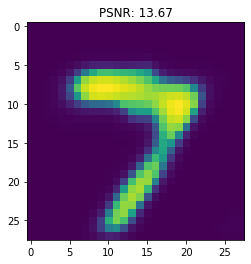

epoch: 150 loss: 0.12108


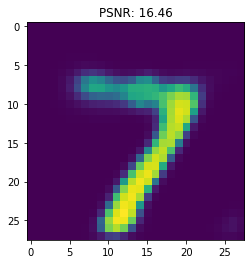

epoch: 200 loss: 0.08815


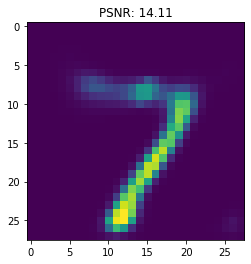

epoch: 250 loss: 0.06703


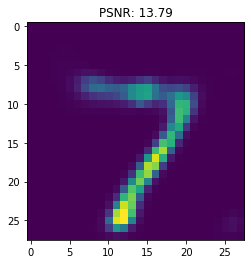

epoch: 300 loss: 0.06571


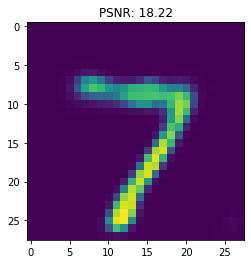

epoch: 350 loss: 0.56293


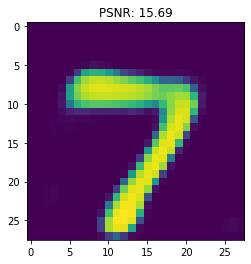

epoch: 400 loss: 0.04265


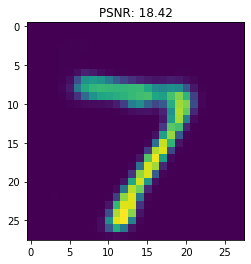

epoch: 450 loss: 0.03003


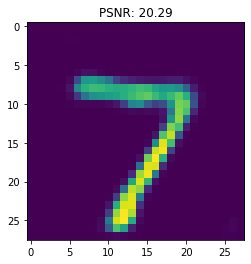

epoch: 500 loss: 0.03632


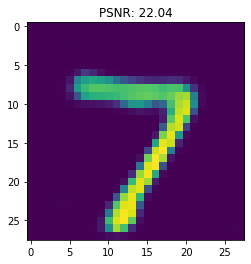

epoch: 550 loss: 0.02600


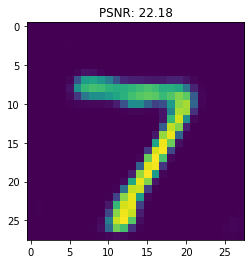

epoch: 600 loss: 0.02132


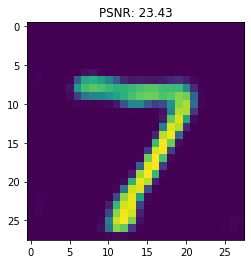

epoch: 650 loss: 0.10439


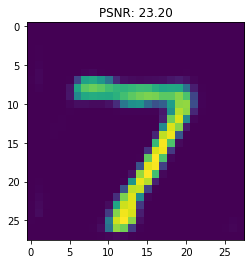

epoch: 700 loss: 0.01972


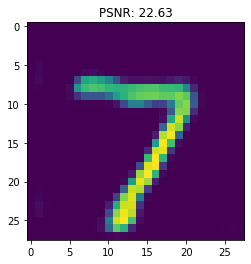

epoch: 750 loss: 0.01858


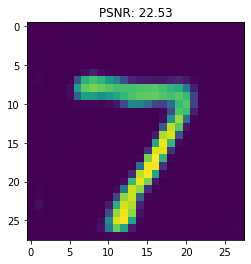

epoch: 800 loss: 0.02577


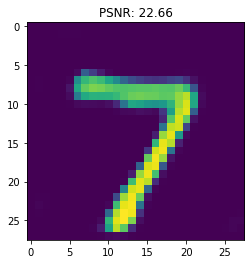

epoch: 850 loss: 0.01826


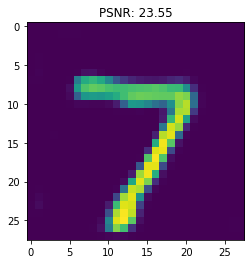

epoch: 900 loss: 0.01476


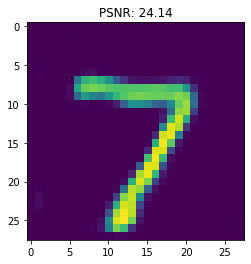

epoch: 950 loss: 0.01359


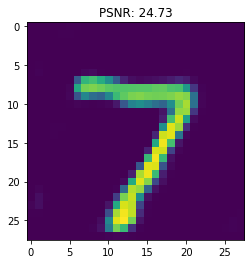

In [7]:
from skimage.measure import compare_psnr

model.to(device)

def PSNR(imtrue, imother):
    return compare_psnr(imtrue, imother, data_range=imtrue.max() - imtrue.min())

# iterate over epochs
z = 0.01 * torch.randn(phantom.shape)
z = z.to(device)
sinogram = sinogram.to(device)
operator = torch.tensor(operator, dtype=torch.float32).to(device)

for i in range(n_epochs):
  
    model.train()
    optimizer.zero_grad()
    output = model(z).view(-1)
    loss = loss_function(torch.matmul(operator, output), sinogram.view(-1))
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
      print('epoch: %d loss: %.5f' % (i, loss.item()))
      model.eval()
      x_rec = model(z).detach().cpu().numpy()
      plt.imshow(x_rec.squeeze())

      plt.title('PSNR: %.2f' % PSNR(x_rec.squeeze(), phantom.numpy().squeeze()))
      plt.show()

## Show reconstruction result


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0.5, 1.0, 'PSNR: 25.24')

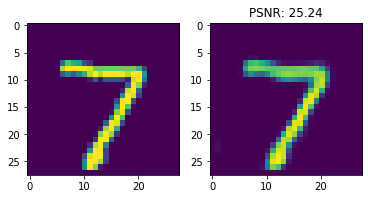

In [9]:
model.eval()

plt.subplot(1, 2, 1)
plt.imshow(phantom.squeeze())

plt.subplot(1, 2, 2)
x_rec = model(z).detach().cpu().numpy()
plt.imshow(x_rec.squeeze())
plt.title('PSNR: %.2f' % PSNR(x_rec.squeeze(), phantom.numpy().squeeze()))